In [1]:
import glob
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1-Read Dataset

In [2]:
imgs = glob.glob("./img_final/*.png")

In [3]:
width = 125
height = 50

X = []
Y = []

## 2-Preprocessing

In [4]:
# example image
imgs[0] # first image

'./img_final\\down_d3676756-fa1a-4fcf-9676-cdd4f5f25c40_100.png'

In [5]:
# example image
filename0 = os.path.basename(imgs[0])
filename0

'down_d3676756-fa1a-4fcf-9676-cdd4f5f25c40_100.png'

In [6]:
filename0.split('_')

['down', 'd3676756-fa1a-4fcf-9676-cdd4f5f25c40', '100.png']

In [7]:
filename0.split('_')[0]

'down'

In [8]:
for img in imgs:
    
    filename = os.path.basename(img)
    label = filename.split("_")[0] # target = down, up, right
    im = np.array(Image.open(img).convert("L").resize((width, height))) # resize image
    im = im / 255 # 0-1 normalize
    X.append(im) # x = images
    Y.append(label) # y = labels(target)
    
X = np.array(X) # converting array before train split
X = X.reshape(X.shape[0], width, height, 1) # 1=gray

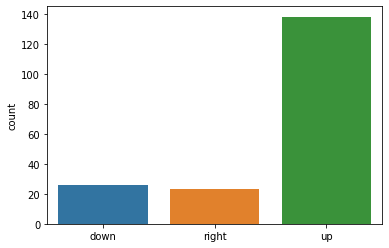

In [9]:
sns.countplot(Y)
plt.show()

In [10]:
Y[0:5]

['down', 'down', 'down', 'down', 'down']

### NOTE
- **Label Encoder**
  - down => 0, 
  - right => 1,
  - up   => 2, 
<br><br>

- **One Hot Encoder**
  - 0 => 100, 
  - 1 => 010, 
  - 2 => 001

In [11]:
def onehot_labels(values):
    label_encoder = LabelEncoder() 
    integer_encoded = label_encoder.fit_transform(values)
    
    onehot_encoder = OneHotEncoder(sparse = False) # no sparce matrix
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1) # (169,) => (169,1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [12]:
Y = onehot_labels(Y)
Y[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## 3-Split Data

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, Y , test_size = 0.25, random_state = 42) 

## 4-Create and Compile CNN Model

In [14]:
model = Sequential()   

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = (width, height, 1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(rate = 0.4))
model.add(Dense(units = 3, activation = "softmax")) # output = 3 => use softmax > 2 output

### NOTE
- Başlangıçta loss(kayıp) yani hata çok yüksek çıkıyor ve bu kayba göre parametreler, (backpropagation)geriye doğru gidilerek yani türev alınarak güncellenir.
- Eğer loss çok azsa model iyi eğitilmiş olacaktır.

In [15]:
model.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

## 5-Train Model

In [16]:
model.fit(train_X, train_y, epochs = 50, batch_size = 64)

Epoch 1/50
3/3 [==============================] - 2s 481ms/step - loss: 4.3868 - accuracy: 0.4714
Epoch 2/50
3/3 [==============================] - 2s 551ms/step - loss: 1.6049 - accuracy: 0.7429
Epoch 3/50
3/3 [==============================] - 2s 570ms/step - loss: 1.0334 - accuracy: 0.4286
Epoch 4/50
3/3 [==============================] - 2s 520ms/step - loss: 0.7365 - accuracy: 0.7500
Epoch 5/50
3/3 [==============================] - 2s 573ms/step - loss: 0.7520 - accuracy: 0.7500
Epoch 6/50
3/3 [==============================] - 2s 537ms/step - loss: 0.7021 - accuracy: 0.7500
Epoch 7/50
3/3 [==============================] - 2s 504ms/step - loss: 0.6395 - accuracy: 0.7500
Epoch 8/50
3/3 [==============================] - 2s 513ms/step - loss: 0.5142 - accuracy: 0.7500
Epoch 9/50
3/3 [==============================] - 2s 469ms/step - loss: 0.4681 - accuracy: 0.8071
Epoch 10/50
3/3 [==============================] - 2s 551ms/step - loss: 0.4364 - accuracy: 0.7786
Epoch 11/50
3/3 [==

In [17]:
open("model.json","w").write(model.to_json())
model.save_weights("model.h5")

In [18]:
# if os.path.exists("./trex_weight.h5"):
#     model.load_weights("trex_weight.h5")
#     print("Weights yuklendi")    

## 6-Evaluate Model

In [19]:
score_train = model.evaluate(train_X, train_y)
print("Train Accuracy: %", score_train[1]*100)   # score[0]=loss

5/5 [==============================] - 1s 71ms/step - loss: 0.1454 - accuracy: 0.9429
Train Accuracy: % 94.28571462631226


In [20]:
score_test = model.evaluate(test_X, test_y)
print("Test Accuracy: %", score_test[1]*100)     # score[0]=loss 

2/2 [==============================] - 0s 47ms/step - loss: 0.2579 - accuracy: 0.8936
Test Accuracy: % 89.3617033958435


- %5 lük bir fark var overfitting.